<a href="https://colab.research.google.com/github/xyhan-github/BlogRepo/blob/master/Visualize_ViTMoE7_noaux_(Recolor).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import torchvision.transforms as transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights

from IPython import embed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
num_epochs = 100
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.1
batch_size = 1024
num_classes = 10
name = 'ViTMoE7_noaux'
checkpoint_path = f'/content/drive/MyDrive/{name}/checkpoints'
num_images_per_class = 100 # Image classes for visualization

In [4]:
# 1. Load CIFAR10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ViT input size
    transforms.ToTensor(),
    transforms.Normalize([x / 255.0 for x in [125.3, 123.0, 113.9]],
                         [x / 255.0 for x in [63.0, 62.1, 66.7]])
])
trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/data/CIFAR10',
                                        train=True, download=True,
                                        transform=transform)


Files already downloaded and verified


In [5]:
# Create a new dataset with the desired subset
subset_trainset = []
for i in range(num_classes):
  class_indices = [idx for idx, label in enumerate(trainset.targets) if label == i]
  subset_indices = class_indices[:num_images_per_class]
  subset_trainset += subset_indices

trainset = Subset(trainset, subset_trainset)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=num_classes*num_images_per_class, # Load everything at once
                                          shuffle=False, pin_memory=False,
                                          num_workers=os.cpu_count())

In [7]:
# 2. Load Pretrained ViT Model
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 170MB/s]


In [8]:
# Define MoE Block
class MoEBlock(nn.Module):
    def __init__(self, num_experts, in_features, out_features, top_k):
        super(MoEBlock, self).__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.GELU(),
                nn.Dropout(p=0.0),
                nn.Linear(out_features, in_features),
                nn.Dropout(p=0.0)
            ) for _ in range(num_experts)
        ])
        self.in_features = in_features
        self.gate = nn.Linear(in_features, num_experts)

    def forward(self, x):
        batch_size = x.size(0)

        # Keep only classification token
        x = x[:, [0]]

        # Compute gating scores
        gating_scores = self.gate(x)  # [batch_size, tokens, num_experts]

        # Get top-k indices and values from the gating scores
        top_k_values, top_k_indices = torch.topk(gating_scores, self.top_k, dim=2)

        # Apply softmax to top-k gating scores
        top_k_weights = F.softmax(top_k_values, dim=2)

        # Create dictionary of examples assigned to each expert
        expert_examples = {}
        expert_weights  = {}
        for i in range(self.num_experts):
            expert_examples[i] = []
            expert_weights[i] = []

        for j in range(batch_size):
            for k in range(self.top_k):
                expert_examples[top_k_indices[j,0, k].item()].append(j)
                expert_weights[top_k_indices[j,0, k].item()].append(top_k_weights[j,0, k])

        # Compute forward pass using correctly selected experts
        output = torch.zeros(batch_size, 1, self.in_features, device=x.device)
        for ex in range(self.num_experts):
          if len(expert_examples[ex]) > 0:
            # Subset x by indices in expert_examples
            x_subset = x[expert_examples[ex]]
            output[expert_examples[ex]] += self.experts[ex](x_subset) * torch.stack(expert_weights[ex]).view(-1, 1, 1)

        return output + x

# Example of replacing a layer with MoEBlock
# Assuming `encoder` is your model and `encoder.layers.encoder_layer_11.mlp` is the layer to replace
moe_layer = MoEBlock(num_experts=3, in_features=768, out_features=3072, top_k=2)
model.encoder.layers.encoder_layer_11.mlp = moe_layer


# Adjust the final classifier for correct number of classes
num_ftrs = model.heads.head.in_features
model.heads.head = torch.nn.Linear(num_ftrs, num_classes)

In [9]:
# load model
# push the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load pretrained model from google drive
checkpoint = torch.load(checkpoint_path + '/vitb16_epoch=300.pth', map_location=device)
model.load_state_dict(checkpoint)

# Set requires grad to fals for eval
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [10]:
augweights = torch.cat([moe_layer.gate.weight,
                        moe_layer.gate.bias.view(-1,1)], dim=1)
U, S, V = torch.svd(augweights)
basis = V[:,0:2]

basis3D = V[:, 0:3]

In [11]:
augweights_vis = (augweights @ basis).cpu().numpy()
augweights_3D = (augweights @ basis3D).cpu().numpy()

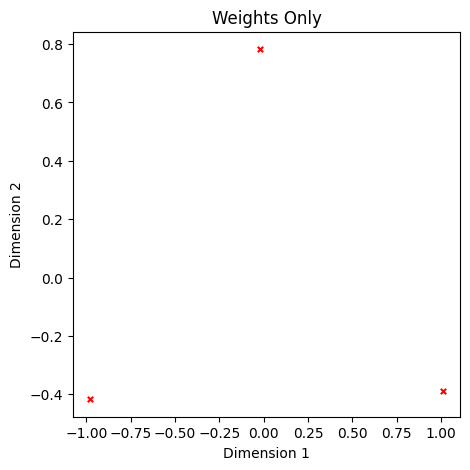

In [12]:
# Plot the rows of augweight_vis
plt.figure(figsize=(5,5))
plt.scatter(augweights_vis[:, 0], augweights_vis[:, 1], s=15,  c='red', marker='x')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Weights Only')
plt.show()

# NOTE: There are two sets of two weight rows that overlap with each other (see above)
# so, it looks like there are only 4 points

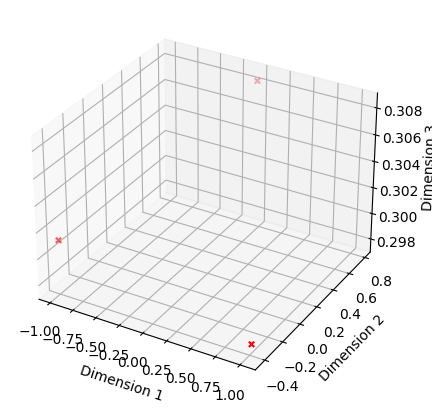

In [13]:
# Plot the augweights3D as 3D scatterplot

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(augweights_3D[:, 0], augweights_3D[:, 1], augweights_3D[:, 2], s=15,  c='red', marker='x')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

plt.show()


In [14]:
# Load everything
imgs, targets = next(iter(trainloader))
imgs = imgs.to(device)
targets = targets.to(device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [15]:
# # Hook inputs of gate
gate_inputs = []

def hook_fn_inputs(module, input, output):
    # Ensure the function takes module, input, and output parameters
    gate_inputs.append(input[0].detach())

# Assuming model and imgs are correctly defined
# Register the hook function
hook = moe_layer.gate.register_forward_hook(hook_fn_inputs)

# "gate" = G(x)
# input(gate) = x

# Pass images through the model
model(imgs)

# If you do this more than once, you have to call gate_inputs.clear() within a for loop

# Remove the hook function
hook.remove()

In [16]:
x = gate_inputs[0].squeeze()
augx = torch.cat([x, torch.ones(x.shape[0]).view(x.shape[0],1).to(device)], dim=1)

In [17]:
x_all = torch.stack([expert(x) for expert in moe_layer.experts]) # apply experts
x_all = x[None,:,:] + x_all # residual connection
x_all = model.encoder.ln(x_all) # layer_norm
x_all = model.heads(x_all) # linear layer
x_all = x_all.permute(1,0,2) # examples x experts x 10-logits

In [18]:
yex = torch.stack([x_all[i, :, targets[i]] for i in range(x_all.shape[0])])

In [19]:
Rx = yex.argmax(dim=1).cpu().numpy()

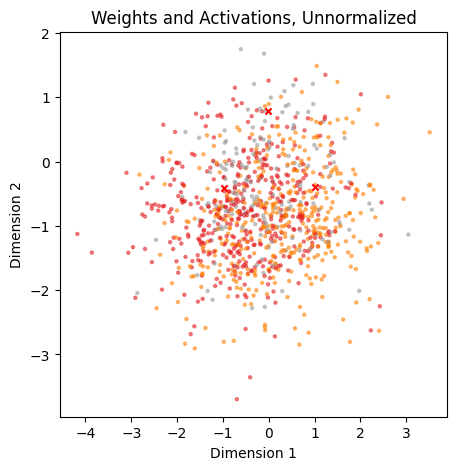

In [20]:
augx_vis = (augx @ basis).cpu().numpy()
plt.figure(figsize=(5,5))
plt.scatter(augx_vis[:, 0], augx_vis[:, 1], s=5, c=Rx,
            cmap='Set1', alpha=0.5)
plt.scatter(augweights_vis[:, 0], augweights_vis[:, 1], s=20,  c='red', marker='x')
plt.title("Weights and Activations, Unnormalized")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# The activations are nowhere on the same scale as weights

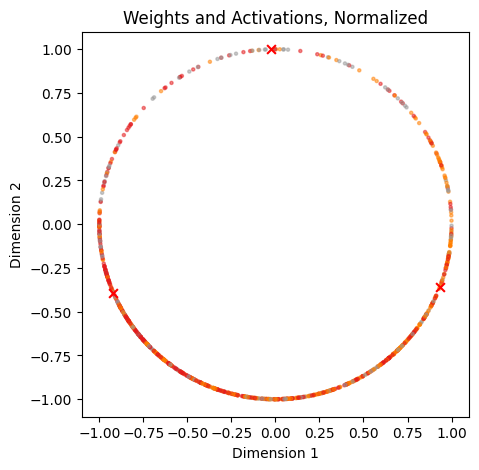

In [21]:
# Rescale the rows of augweights_vis and augx_vis to unit norm
import numpy as np
plt.figure(figsize=(5,5))
augweights_vis_normed = augweights_vis / np.linalg.norm(augweights_vis, axis=1, keepdims=True)
augx_vis_normed = augx_vis / np.linalg.norm(augx_vis, axis=1, keepdims=True)

plt.scatter(augx_vis_normed[:, 0], augx_vis_normed[:, 1], s=5, c=Rx,
            cmap='Set1', alpha=0.5)
plt.scatter(augweights_vis_normed[:, 0], augweights_vis_normed[:, 1], s=40,  c='red', marker='x')
plt.title("Weights and Activations, Normalized")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [22]:
augx3D = (augx @ basis3D).cpu().numpy()
augweights3D_normed = augweights_3D / np.linalg.norm(augweights_3D, axis=1, keepdims=True)
augx3D_normed = augx3D / np.linalg.norm(augx3D, axis=1, keepdims=True)

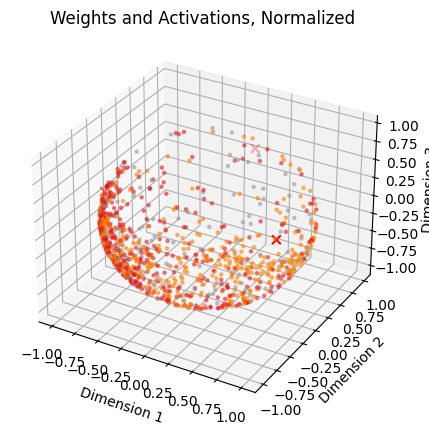

In [23]:
# prompt: plot augweights3D_normed and augx3D_normed as 3D scatterplot

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(augx3D_normed[:, 0], augx3D_normed[:, 1], augx3D_normed[:, 2], s=5, c=Rx,
            cmap='Set1', alpha=0.5)
ax.scatter(augweights3D_normed[:, 0], augweights3D_normed[:, 1], augweights3D_normed[:, 2], s=40,  c='red', marker='x')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.title("Weights and Activations, Normalized")
plt.show()


In [24]:
# prompt: save augx3D and augweights_3D as CSVs in /content/drive/MyDrive/ViTMoE/checkpoints

import csv

with open(checkpoint_path + '/augx3D.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(augx3D)

with open(checkpoint_path + '/augweights3D.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(augweights_3D)


# Activation Basis

In [25]:
_, _, Vx = torch.svd(augx)
xBasis3D = Vx[:,0:3]

augweights3D_xb = (augweights @ xBasis3D).cpu().numpy()
augx3D_xb = (augx @ xBasis3D).cpu().numpy()

augweights3D_xb_normed = augweights3D_xb / np.linalg.norm(augweights3D_xb, axis=1, keepdims=True)
augx3D_xb_normed = augx3D_xb / np.linalg.norm(augx3D_xb, axis=1, keepdims=True)

In [26]:
xBasis2D = Vx[:,0:2]

augweights2D_xb = (augweights @ xBasis2D).cpu().numpy()
augx2D_xb = (augx @ xBasis2D).cpu().numpy()

augweights2D_xb_normed = augweights2D_xb / np.linalg.norm(augweights2D_xb, axis=1, keepdims=True)
augx2D_xb_normed = augx2D_xb / np.linalg.norm(augx2D_xb, axis=1, keepdims=True)

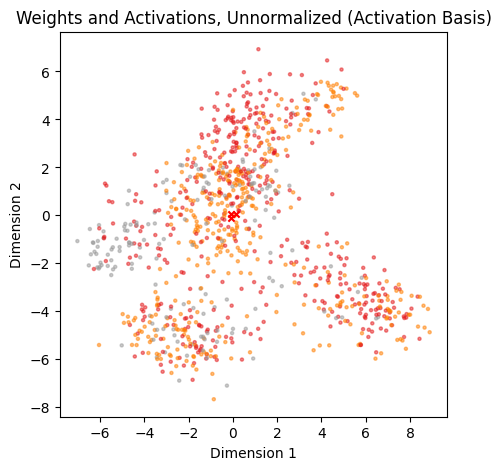

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(augx2D_xb[:, 0], augx2D_xb[:, 1], s=5, c=Rx,
            cmap='Set1', alpha=0.5)
plt.scatter(augweights2D_xb[:, 0], augweights2D_xb[:, 1], s=20,  c='red', marker='x')
plt.title("Weights and Activations, Unnormalized (Activation Basis)")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

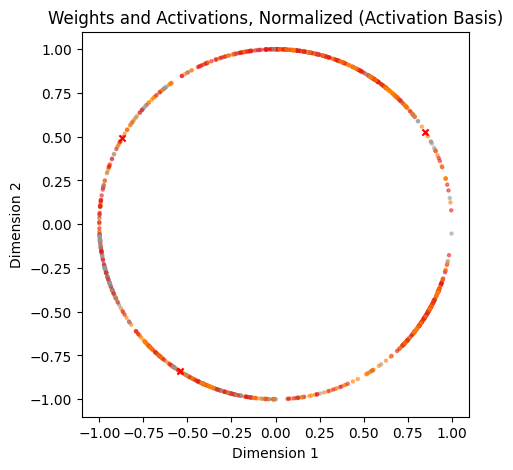

In [28]:
plt.figure(figsize=(5,5))
plt.scatter(augx2D_xb_normed[:, 0], augx2D_xb_normed[:, 1], s=5, c=Rx,
            cmap='Set1', alpha=0.5)
plt.scatter(augweights2D_xb_normed[:, 0], augweights2D_xb_normed[:, 1], s=20,  c='red', marker='x')
plt.title("Weights and Activations, Normalized (Activation Basis)")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

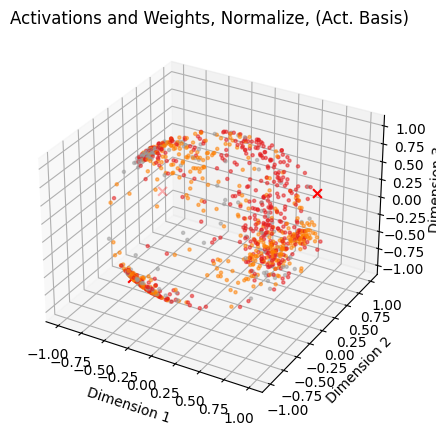

In [29]:
# Plot in activation basis

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(augx3D_xb_normed[:, 0], augx3D_xb_normed[:, 1], augx3D_xb_normed[:, 2], s=5, c=Rx,
            cmap='Set1', alpha=0.5)
ax.scatter(augweights3D_xb_normed[:, 0], augweights3D_xb_normed[:, 1], augweights3D_xb_normed[:, 2], s=40,  c='red', marker='x')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.title("Activations and Weights, Normalize, (Act. Basis)")
plt.show()